In [3]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
torch.manual_seed(0)


## Separating and Labeling Data

In [37]:
all_files = []
labels = []
train_directory = "Data/"
for letter in os.listdir(train_directory):
    letter_dir = os.path.join(train_directory, letter)
    letter_files = [os.path.join(letter_dir,file) for file in os.listdir(letter_dir) if file.endswith(".jpg")]
    letter_files.sort()
    for sample in letter_files:
        labels.append(ord(letter)%97)


In [40]:
class Dataset(Dataset):
    def __init__(self, transform=None, train=True):
        self.all_files = []
        self.labels = []
        self.transform = transform

        for letter in os.listdir(train_directory):
            letter_dir = os.path.join(train_directory, letter)
            letter_files = [os.path.join(letter_dir,file) for file in os.listdir(letter_dir) if file.endswith(".jpg")]
            letter_files.sort()
            for sample in letter_files:
                label = ord(letter)%97 # Modularlly divides by 97 to label chars a-z with ints 0-25
                self.labels.append(label)
                self.all_files.append(sample)
        
        random.seed(1)
        random.shuffle(self.all_files)
        random.shuffle(self.labels)
        # Shuffle the order of the images
        # Using a 90/10 split
        if train:
            self.all_files = self.all_files[::2060]
            self.labels = self.labels[::2060]
            self.len = len(self.all_files)
        else: 
            self.all_files = self.all_files[2060::]
            self.labels = self.labels[2060::]
            self.len = len(self.all_files)
        
    def __len__(self):
        return self.len

    def __getitem__(self, id):
        image = Image.open(self.all_files[id])
        label = self.labels[id]

        if self.transform: # Apply a transform if needed
            image = self.transform(image)

        return image, label

## Creating Dataset

In [41]:
train_dataset = Dataset(transform=transforms.ToTensor(), train=True)
mean, mean_squared = 0.0, 0.0

for image, _ in train_dataset:
    mean += image[0].mean()
    mean_squared += torch.mean(image**2)

mean = mean/len(train_dataset)
#std = sqrt(E[X^2] - (E[X])^2)
std = (mean_squared / len(train_dataset) - mean ** 2) ** 0.5

composed = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
train_dataset = Dataset(transform=composed, train=True)
validation_dataset = Dataset(transform=composed, train=False)

## Linear Classifier

In [42]:
class SoftMax(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        # Creates a layer of given input size and output size
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        # Runs the x value through the single layers defined above
        z = self.linear(x)
        return z

In [89]:
# Linear classifier here
input_dimension = 160 * 148 # Dimensions of each image
output_dimension = 26 # Number of lowercase characters 
model = SoftMax(input_dimension, output_dimension)

# We want the model to run on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.cuda()

trainloader = DataLoader(dataset=train_dataset, batch_size=1)
validationloader = DataLoader(dataset=validation_dataset, batch_size=1)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [99]:
loss_list = []
accuracy_list = []

def trainModel(num_epochs):
    for epoch in range(num_epochs):
        for x,y in trainloader:
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            model.train()
            prediction = model(x.view(-1, 148*160))
            loss = criterion(prediction,y)
            loss.backward()
            optimizer.step()

        num_correct = 0
        for x_test, y_test in validationloader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            prediction = model(x_test.view(-1, 148*160))
            # Find the class with the highest output
            _, yhat = torch.max(prediction.data, 1)
            num_correct += (yhat == y_test).sum().item()
        accuracy = len(validation_dataset) / num_correct
        loss_list.append(loss.cpu().data)
        accuracy_list.append(accuracy)

trainModel(50)

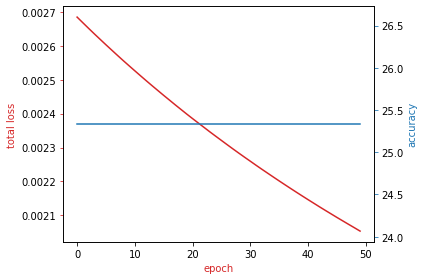

In [100]:
# Handy plotting info
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
   
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [101]:
print(loss_list)
print(max(accuracy_list))

[tensor(0.0027), tensor(0.0027), tensor(0.0027), tensor(0.0026), tensor(0.0026), tensor(0.0026), tensor(0.0026), tensor(0.0026), tensor(0.0026), tensor(0.0025), tensor(0.0025), tensor(0.0025), tensor(0.0025), tensor(0.0025), tensor(0.0025), tensor(0.0025), tensor(0.0024), tensor(0.0024), tensor(0.0024), tensor(0.0024), tensor(0.0024), tensor(0.0024), tensor(0.0024), tensor(0.0023), tensor(0.0023), tensor(0.0023), tensor(0.0023), tensor(0.0023), tensor(0.0023), tensor(0.0023), tensor(0.0023), tensor(0.0022), tensor(0.0022), tensor(0.0022), tensor(0.0022), tensor(0.0022), tensor(0.0022), tensor(0.0022), tensor(0.0022), tensor(0.0022), tensor(0.0021), tensor(0.0021), tensor(0.0021), tensor(0.0021), tensor(0.0021), tensor(0.0021), tensor(0.0021), tensor(0.0021), tensor(0.0021), tensor(0.0021)]
25.333333333333332
